In [1]:
%load_ext autoreload
%autoreload 2

import src.multiagent_mpc as mpc
import src.traffic_world as tw
import src.car_plotting_multiple as cmplot
import glob
import argparse
import json
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['text.usetex'] = True

In [3]:
all_logs = glob.glob('/home/nbuckman/mpc_results/svo/*') + glob.glob('/home/nbuckman/mpc_results/cntrl2/*')

In [4]:
d_seed_param_dist = dict()
for s in range(10):
    d_seed_param_dist[s] = dict()

In [5]:
for LOG_DIRECTORY in all_logs:
    LOG_DIRECTORY += '/'
    TRAJ_PATH = LOG_DIRECTORY + 'trajectories.npy'
    PARAMS_PATH = LOG_DIRECTORY + 'params.json'
    try:
        trajectory = np.load(open(TRAJ_PATH,'rb'))
    except FileNotFoundError:
        continue
    xamb = trajectory[0, :, :]
    xothers = trajectory[1:, :, :]

    # Load data
    with open(PARAMS_PATH) as fp:
        params = json.load(fp)
    
    seed = params["seed"]
    
    n_cntrld = params["n_cntrld"]
    rnds_shrd_cntrl = params["rnds_shrd_cntrl"]
    svo = params['svo_theta']
    random_svo = params['random_svo']
    settings = (n_cntrld, rnds_shrd_cntrl, random_svo, svo)
    
    # we delete repeat experiments
    d_seed_param_dist[seed][settings] = (xamb[0,-1] - xamb[0,0])


In [6]:
def radian_to_pi_string(svo_radian):
    if -5 * np.pi/180 < svo_radian < 5 * np.pi/180:
        return "0"
    else:
        divisor = np.pi/svo_radian
        divisor = int(np.round(divisor))
        return '$\\pi$/%d'%divisor
        
    
    

In [7]:
d_seed_idm_dist = dict()
for s in range(11):
    d_seed_idm_dist[s] = dict()
idm_logs = glob.glob('/home/nbuckman/mpc_results/idm_3_5_logs/*')

for LOG_DIRECTORY in idm_logs:
    LOG_DIRECTORY += '/'
    TRAJ_PATH = LOG_DIRECTORY + 'trajectories.npy'
    PARAMS_PATH = LOG_DIRECTORY + 'params.json'
    try:
        trajectory = np.load(open(TRAJ_PATH,'rb'))
    except FileNotFoundError:
        continue
    xamb = trajectory[0, :, :]
    xothers = trajectory[1:, :, :]

    # Load data
    with open(PARAMS_PATH) as fp:
        params = json.load(fp)
    
    seed = params["seed"]
    
    n_cntrld = params["n_cntrld"]
    rnds_shrd_cntrl = params["rnds_shrd_cntrl"]
    svo = params['svo_theta']
    random_svo = params['random_svo']
    settings = (n_cntrld, rnds_shrd_cntrl, random_svo, svo)
    
    # we delete repeat experiments
    d_seed_idm_dist[seed][settings] = (xamb[0,-1] - xamb[0,0])


In [8]:
d_seed_idm_dist[0]

{(2, 2, 0, 1.56): 666.2802045815597,
 (2, 2, 0, 0.0): 666.0102410007446,
 (2, 2, 0, 0.785): 666.2802045815597}

In [9]:
d_seed_param_dist[0]

{(2, 2, 0, 0.0): 677.3224252837889,
 (2, 2, 0, 0.7854): 801.1416681114703,
 (2, 2, 0, 1.56): 801.1416693175702,
 (2, 2, 0, -0.7854): 677.2242172532676,
 (2, 2, 0, 0.5235): 800.6464775793035,
 (2, 4, 1, 0.0): 799.6864951067707,
 (3, 2, 1, 0.0): 800.7135815406041,
 (2, 3, 1, 0.0): 800.6462146929401,
 (2, 2, 1, 0.0): 800.4815861688465,
 (2, 1, 1, 0.0): 800.4309894730154,
 (1, 2, 1, 0.0): 677.3377602596404,
 (0, 2, 1, 0.0): 677.3382411474159}

In [10]:
PLOT_DIR = '/home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/iros_plots/'

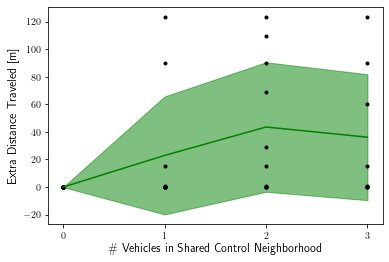

In [11]:
all_data = []

for n_cntrl in range(4):
    exp_cntrl_setting = (n_cntrl, 2, 1, 0.0)
    baseline_no_cntrl_setting = (0, 2, 1, 0.0)
    
    valid_seeds = [s for s in d_seed_param_dist if (exp_cntrl_setting in d_seed_param_dist[s] 
                                                    and baseline_no_cntrl_setting in d_seed_param_dist[s])]
    
    speed_up = [(d_seed_param_dist[s][exp_cntrl_setting] - d_seed_param_dist[s][baseline_no_cntrl_setting]) for s in valid_seeds]
    plt.plot([n_cntrl for s in range(len(speed_up))], speed_up,'.', color='black')
    all_data += [(n_cntrl, speed_up)]
    
plt.plot([d[0] for d in all_data], [np.mean(d[1]) for d in all_data], color='green' )
plt.fill_between([d[0] for d in all_data], 
                 [np.mean(d[1]) - np.std(d[1]) for d in all_data], 
                 [np.mean(d[1]) + np.std(d[1]) for d in all_data], alpha=0.5, color='green'
                )
# plt.title("Ablation:  Effect of # Vehicles in Cntrl Region", family='serif')
plt.ylabel("Extra Distance Traveled [m]", family='serif', fontsize=12)
plt.xlabel("\# Vehicles in Shared Control Neighborhood", family='serif', fontsize=12)
plt.xticks(range(4))
# plt.show()
plt.savefig(PLOT_DIR + 'ablation_n_nctrl'+ ".pdf", transparent=True, bbox_inches='tight')

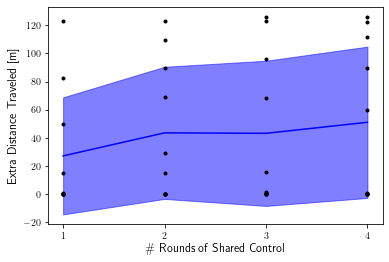

In [12]:
all_data = []
for n_rnds_shrd_cntrl in range(1, 5):
    exp_cntrl_setting = (2, n_rnds_shrd_cntrl, 1, 0.0)
    baseline_no_cntrl_setting = (0, 2, 1, 0.0)
    
    valid_seeds = [s for s in d_seed_param_dist if (exp_cntrl_setting in d_seed_param_dist[s] 
                                                    and baseline_no_cntrl_setting in d_seed_param_dist[s])]
    
    speed_up = [(d_seed_param_dist[s][exp_cntrl_setting] - d_seed_param_dist[s][baseline_no_cntrl_setting]) for s in valid_seeds]
    plt.plot([n_rnds_shrd_cntrl for s in range(len(speed_up))], speed_up,'.', color='black')
    all_data += [(n_rnds_shrd_cntrl, speed_up)]

plt.plot([d[0] for d in all_data], [np.mean(d[1]) for d in all_data], color='blue')
plt.fill_between([d[0] for d in all_data], 
                 [np.mean(d[1]) - np.std(d[1]) for d in all_data], 
                 [np.mean(d[1]) + np.std(d[1]) for d in all_data], alpha=0.5, color='blue'
                )
    
# plt.title("Ablation:  Effect of # Rnds Shrd Cntrl")
plt.ylabel("Extra Distance Traveled [m]", family='serif', fontsize=12)
plt.xlabel("\# Rounds of Shared Control", family='serif', fontsize=12)
# plt.show()
plt.xticks(range(1,5))

plt.savefig(PLOT_DIR + 'ablation_rnds_shrd_ctrl'+ ".pdf", transparent=True,bbox_inches='tight')

# Classic SVO

In [15]:
all_svos = sorted(list(set([setting[-1] for setting in d_seed_param_dist[0]])))
print(all_svos)

[-0.7854, 0.0, 0.5235, 0.7854, 1.56]


In [16]:
d_seed_param_dist[0]

{(2, 2, 0, 0.0): 677.3224252837889,
 (2, 2, 0, 0.7854): 801.1416681114703,
 (2, 2, 0, 1.56): 801.1416693175702,
 (2, 2, 0, -0.7854): 677.2242172532676,
 (2, 2, 0, 0.5235): 800.6464775793035,
 (2, 4, 1, 0.0): 799.6864951067707,
 (3, 2, 1, 0.0): 800.7135815406041,
 (2, 3, 1, 0.0): 800.6462146929401,
 (2, 2, 1, 0.0): 800.4815861688465,
 (2, 1, 1, 0.0): 800.4309894730154,
 (1, 2, 1, 0.0): 677.3377602596404,
 (0, 2, 1, 0.0): 677.3382411474159}

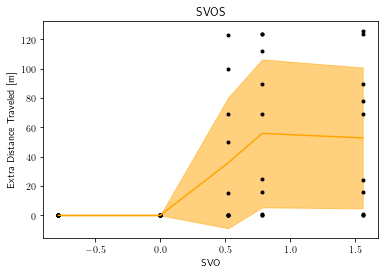

In [17]:
all_svo_data = []
for svo in all_svos:
    exp_cntrl_setting = (2, 2, 0, svo)
    baseline_no_cntrl_setting = (2, 2, 0, 0.0)
    
    valid_seeds = [s for s in d_seed_param_dist if (exp_cntrl_setting in d_seed_param_dist[s] 
                                                    and baseline_no_cntrl_setting in d_seed_param_dist[s])]
    
    speed_up = [(d_seed_param_dist[s][exp_cntrl_setting] - d_seed_param_dist[s][baseline_no_cntrl_setting]) for s in valid_seeds]
    plt.plot([svo for s in range(len(speed_up))], speed_up,'.', color='black')
    all_svo_data += [(svo, speed_up)]

plt.plot([d[0] for d in all_svo_data], [np.mean(d[1]) for d in all_svo_data], color='orange')
plt.fill_between([d[0] for d in all_svo_data], 
                 [np.mean(d[1]) - np.std(d[1]) for d in all_svo_data], 
                 [np.mean(d[1]) + np.std(d[1]) for d in all_svo_data], alpha=0.5, color='orange'
                )
    
plt.title("SVOS")
plt.ylabel("Extra Distance Traveled [m]")
plt.xlabel("SVO ")
plt.savefig(PLOT_DIR + 'baseline_svo'+ ".pdf", transparent=True)
# plt.show()

In [18]:
plt.plot([d[0] for d in all_svo_data if d[0]>=0], [np.mean(d[1]) for d in all_svo_data if d[0]>=0], color='red')
plt.fill_between([d[0] for d in all_svo_data if d[0]>=0], 
                 [np.mean(d[1]) - np.std(d[1]) for d in all_svo_data if d[0]>=0], 
                 [np.mean(d[1]) + np.std(d[1]) for d in all_svo_data if d[0]>=0], alpha=0.5, color='red'
                )
    
plt.title("SVOS:  Effect of # Rnds Shrd Cntrl")
plt.ylabel("Extra Distance Traveled [m]")
plt.xlabel("# Rnds Shrd Cntrl")
plt.savefig(PLOT_DIR + 'baseline_svo_pos'+ ".pdf", transparent=True)

# plt.show()

RuntimeError: latex was not able to process the following string:
b'SVOS:  Effect of # Rnds Shrd Cntrl'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/nbuckman/.cache/matplotlib/tex.cache/3ceb4847ebb12b7d0baf81853ded894e.te
x
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
(./3ceb4847ebb12b7d0baf81853ded894e.aux)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! You can't use `macro parameter character #' in horizontal mode.
l.19 {\sffamily SVOS:  Effect of #
                                   Rnds Shrd Cntrl}
No pages of output.
Transcript written on 3ceb4847ebb12b7d0baf81853ded894e.log.




RuntimeError: latex was not able to process the following string:
b'SVOS:  Effect of # Rnds Shrd Cntrl'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/nbuckman/.cache/matplotlib/tex.cache/3ceb4847ebb12b7d0baf81853ded894e.te
x
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
(./3ceb4847ebb12b7d0baf81853ded894e.aux)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! You can't use `macro parameter character #' in horizontal mode.
l.19 {\sffamily SVOS:  Effect of #
                                   Rnds Shrd Cntrl}
No pages of output.
Transcript written on 3ceb4847ebb12b7d0baf81853ded894e.log.




<Figure size 432x288 with 1 Axes>

# Baseline with IDM

In [19]:
print(d_seed_idm_dist[0])
all_idm_svos = sorted(list(set([setting[-1] for setting in d_seed_idm_dist[0]])))
print(all_idm_svos)

{(2, 2, 0, 1.56): 666.2802045815597, (2, 2, 0, 0.0): 666.0102410007446, (2, 2, 0, 0.785): 666.2802045815597}
[0.0, 0.785, 1.56]


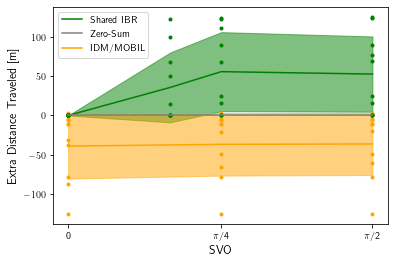

In [21]:


all_idm_data = []
for svo in all_idm_svos:
    
    exp_cntrl_setting = (2, 2, 0, svo)
    baseline_no_cntrl_setting = (2, 2, 0, 0.0)
    
    valid_seeds = [s for s in d_seed_param_dist if (exp_cntrl_setting in d_seed_idm_dist[s] 
                                                    and baseline_no_cntrl_setting in d_seed_param_dist[s])]
    
    speed_up = [(d_seed_idm_dist[s][exp_cntrl_setting] - d_seed_param_dist[s][baseline_no_cntrl_setting]) for s in valid_seeds]
    plt.plot([svo for s in range(len(speed_up))], speed_up,'.', color='orange')
    all_idm_data += [(svo, speed_up)]



#### "Zero Sum"
zero_sum_speed_ups = [d[1] for d in all_svo_data if d[0]<0][0]
zero_sum_data = [(svo, zero_sum_speed_ups) for svo in all_idm_svos]



## Plot Shared IBR
for svo in all_svos:
    if svo<0:
        continue
    exp_cntrl_setting = (2, 2, 0, svo)
    baseline_no_cntrl_setting = (2, 2, 0, 0.0)
    
    valid_seeds = [s for s in d_seed_param_dist if (exp_cntrl_setting in d_seed_param_dist[s] 
                                                    and baseline_no_cntrl_setting in d_seed_param_dist[s])]
    
    speed_up = [(d_seed_param_dist[s][exp_cntrl_setting] - d_seed_param_dist[s][baseline_no_cntrl_setting]) for s in valid_seeds]
    plt.plot([svo for s in range(len(speed_up))], speed_up,'.', color='green')



plt.plot([d[0] for d in all_svo_data if d[0]>=0], [np.mean(d[1]) for d in all_svo_data if d[0]>=0], color='green', label='Shared IBR')
plt.fill_between([d[0] for d in all_svo_data if d[0]>=0], 
                 [np.mean(d[1]) - np.std(d[1]) for d in all_svo_data if d[0]>=0], 
                 [np.mean(d[1]) + np.std(d[1]) for d in all_svo_data if d[0]>=0], alpha=0.5, color='green'
                )


plt.plot([d[0] for d in zero_sum_data ], [np.mean(d[1]) for d in zero_sum_data], color='gray', label='Zero-Sum')
plt.fill_between([d[0] for d in zero_sum_data], 
                 [np.mean(d[1]) - np.std(d[1]) for d in zero_sum_data ], 
                 [np.mean(d[1]) + np.std(d[1]) for d in zero_sum_data ], alpha=0.5, color='gray'
                )

plt.plot([d[0] for d in all_idm_data], [np.mean(d[1]) for d in all_idm_data], color='orange', label="IDM/MOBIL")
plt.fill_between([d[0] for d in all_idm_data], 
                 [np.mean(d[1]) - np.std(d[1]) for d in all_idm_data], 
                 [np.mean(d[1]) + np.std(d[1]) for d in all_idm_data], alpha=0.5, color='orange'
                )


# plt.title("IDM Baselines")
plt.ylabel("Extra Distance Traveled [m]", family='serif', fontsize=12)
plt.xlabel("SVO", family='serif', fontsize=12)
plt.xticks(all_idm_svos, [radian_to_pi_string(s) for s in all_idm_svos])
plt.legend(loc='upper left', prop={'family':'serif'})
# plt.show()
plt.savefig(PLOT_DIR + 'baseline_idm_svo'+ ".pdf", transparent=True,bbox_inches='tight')


In [90]:
for d in all_idm_data:
    print("IDM", d[0], np.mean(d[1]), np.std(d[1]))

IDM 0.0 -39.061849037319156 41.483679254408756
IDM 0.785 -36.84076846333185 39.90616380418824
IDM 1.56 -36.366919877933164 39.59580001442091
